
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 1 <br>
<font color=696880 size=4>
    Niloufar Abbasi 

____

# Emotion Recognition with Recurrent Neural Networks


---

## **Introduction**

In this task, you will implement a Recurrent Neural Network (RNN) to perform tweet emotion recognition. The goal is to classify tweets into one of six basic emotions: 
- **0: sadness**
- **1: joy**
- **2: love**
- **3: anger**
- **4: fear**
- **5: surprise**

We will be using a dataset of tweets, where each tweet has been labeled with one of these emotions. Throughout this notebook, you will follow step-by-step instructions to build and train your model. As you progress, you'll complete the provided TODO sections by filling in the necessary code and functions.

By the end of this exercise, you will:
- Understand how to preprocess text data for use in RNN models.
- Build and train a model using Pytorch.
- Evaluate the performance of your model on the test set.

---


---

## Task 1: Enter Your Information

Before we begin, please enter your **student ID** and **name** in the code section below.

Make sure to replace the placeholders with your actual information.

---

In [32]:
#########################################
# TODO: Enter your personal information #
#########################################

student_name = 'Parsa Ghezelbash'  # Replace with your name
student_id   = '401110437'  # Replace with your student ID

print("Your name:", student_name)
print("Your student ID:", student_id)

Your name: Parsa Ghezelbash
Your student ID: 401110437


---

## Task 2: Setup and Imports

In this task, we'll be preparing our environment by importing the necessary libraries. Please run the cells below to set everything up. If any library is missing on your end, make sure to install it.

### Instructions:
1. **Run the cells** to install any required packages and import the necessary libraries.
2. If any library is not installed in your environment, use `!pip install <library_name>` to install it.
---

In [33]:
!pip install datasets
!pip install tltk

Required Libraries:

In [80]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datasets import load_dataset

%matplotlib inline

#####################################################################
# TODO: Add any additional libraries you may need for your analysis #
#####################################################################
from nltk.tokenize import TweetTokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import WeightedRandomSampler
 
# You can add your libraries here

### Additional Functions

The following functions have been provided to help you visualize the results of your model training. These will allow you to analyze both the model's performance over time (through the training history) and how well it performs on individual predictions (through a confusion matrix).

1. **`plot_history(hist)`**: This function takes the training history object (`hist`) from your model and plots both the accuracy and loss over the number of epochs for both training and validation sets. It provides an easy way to visually track the model's learning progress and performance.

2. **`visualize_confusion_matrix(actual_labels, predicted_labels, classes)`**: After making predictions with your model, you can use this function to plot a confusion matrix. It shows the accuracy of your model across each class, helping to identify areas where the model is performing well and where it might be struggling. The matrix is normalized to make comparisons easier.

These functions are for your convenience, you can directly use them after running your model to visualize the results.


In [164]:
# Functions to visualize training history and confusion matrix
def plot_history(hist):
    epochs = len(hist.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs), hist.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs), hist.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs), hist.history.get('loss'), label='Training')
    plt.plot(range(0, epochs), hist.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def visualize_confusion_matrix(actual_labels, predicted_labels, classes):

    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
    return cm


---

## Task 3: Importing Data

In this task, we will

- import the Tweet Emotion dataset

- create training, validation, and test sets
    
- extract the tweets and their corresponding labels for further analysis

---

In [82]:
dataset = load_dataset('emotion')
dataset

Using the latest cached version of the dataset since emotion couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'split' at C:\Users\Password Please\.cache\huggingface\datasets\emotion\split\0.0.0\cab853a1dbdf4c42c2b3ef2173804746df8825fe (last modified on Wed Dec 25 20:53:05 2024).


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [83]:
# Display the first few samples
print(dataset['train'][0:5])  # Adjust 'train' to 'test' or other splits if necessary

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [84]:
###########################################################################
# TODO: Create variables for the training, validation, and test datasets. #
###########################################################################

training = dataset['train']
validation = dataset['validation']
test = dataset['test']

In [85]:
########################################################################################################
# TODO:                                                                                                #
# Implement the `extract_tweets_labels` function to iterate over the provided dataset.                 #
# Within this function, extract the tweet text and their corresponding labels into two separate lists. #
# Then, call this function with the training dataset to obtain the tweets and labels,                  #
# ensuring proper data handling for subsequent analysis.                                               #
########################################################################################################

def extract_tweets_labels(data):
    # Extract the text and labels from the dat
    tweets = [d['text'] for d in data]
    labels = [d['label'] for d in data]
    return tweets, labels

# Get the tweets and labels from the training set
tweets, labels = extract_tweets_labels(training)

# Display the first tweet and its label
print(tweets[0], labels[0])


i didnt feel humiliated 0


---

## Task 4: Tokenization of Tweets

In this section, we will focus on the tokenization of the tweets in the dataset. Tokenization is a crucial step in natural language processing (NLP) that involves breaking down text into smaller units, such as words or subwords. This process enables the model to better understand and analyze the text data.

### Objectives:
1. Implement a tokenizer to convert the tweet texts into tokens.
2. Ensure the tokenization process handles various aspects of the text, such as punctuation and special characters.

By the end of this task, you will have a set of tokenized tweets ready for further processing in your NLP pipeline.

---

In [148]:
###############################################################################################################################################
# TODO: Tokenization of Tweets                                                                                                                #
# 1. Select a Tokenization Method: Choose a suitable tokenization method to preprocess the tweets.                                            #                                 
# Ensure that the tokenization handles special characters and maintains the integrity of the text data.                                       #
# 2. Implement the Tokenizer: Once you have selected a method, implement the tokenizer to convert the tweet texts into sequences of tokens.   #
# 3. Test the Tokenization:                                                                                                                   #
# Verify the functionality of your tokenizer by applying it to a sample tweet from the dataset and displaying the resulting tokenized output. #
###############################################################################################################################################

tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def tokenize_tweet(tokenizer, tweet):
    return tokenizer.tokenize(tweet)

tokenized_tweets = [tokenize_tweet(tokenizer, tweet) for tweet in tweets]
print(tokenized_tweets[0])

['i', 'didnt', 'feel', 'humiliated']


---

## Task 5: Padding and Truncating Sequences

In this task, we will prepare the tokenized tweets for model training by checking their lengths and creating padded sequences.

1. **Checking the Length of the Tweets**
   - Analyze the distribution of tweet lengths to understand the range of token counts in the dataset.

2. **Creating Padded Sequences**
   - After tokenizing the tweets, sequences of different lengths must be adjusted to a uniform length to facilitate training.

---


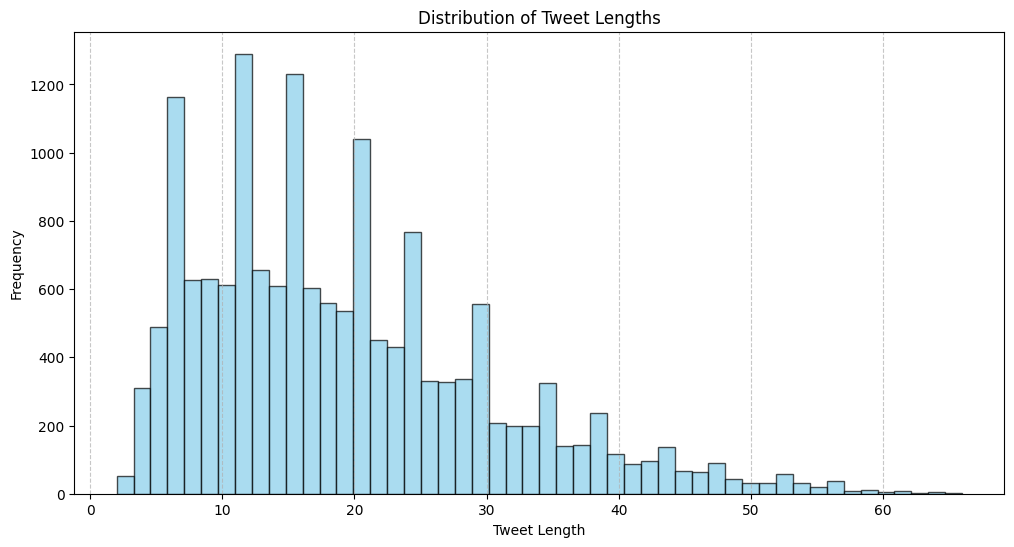

In [ ]:
#####################################################################################################################################################
# TODO:                                                                                                                                             #
# Implement code to calculate the lengths of the tweets and visualize the distribution using a histogram. Use an appropriate visualization library. #
# After visualizing the distribution, determine a suitable maximum length for padding and truncating the sequences based on your findings.          #
#####################################################################################################################################################
tweets_lengths = [len(tokenize_tweet(tokenizer, tweet)) for tweet in tweets]

plt.figure(figsize=(12, 6))
plt.hist(tweets_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [150]:
############################################################################################################
# TODO: Define a function to convert the tokenized tweets into sequences and apply padding and truncation. # 
# Use your determined maximum length for padding the sequences.                                            #
############################################################################################################

def get_sequences(tokenizer, tweets, vocab, max_length=40):
    tokenized_tweets = [tokenize_tweet(tokenizer, tweet) for tweet in tweets]
    sequences = [[vocab[word] for word in tweet if word in vocab] for tweet in tokenized_tweets]
    padded_sequences = pad_sequence([torch.tensor(sequence) for sequence in sequences], batch_first=True)
    padded_sequences = padded_sequences[:, :max_length] if padded_sequences.size(1) > max_length else padded_sequences
    return padded_sequences

vocab = {word: i + 1 for i, word in enumerate({word for tweet in tokenized_tweets for word in tweet})}
vocab['<UNK>'] = len(vocab) + 1
padded_train_sequences = get_sequences(tokenizer, tweets, vocab, max_length=40)
print(padded_train_sequences[0])
print(tweets[0])

tensor([ 9717, 13007,  2633, 10038,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
i didnt feel humiliated


---

## Task 6: Analyzing Label Distribution

1. Checking the distribution of labels.
2. Addressing any class imbalance using appropriate techniques.

Note:

(**Providing a clear explanation of the chosen method to address the imbalance and how it will improve the model’s performance is critical.** Without handling class imbalance properly, the model could achieve a high accuracy by focusing on the majority class, but it may perform poorly on the minority class, which would result in misleading metrics and reduced generalization.

Hence, it is important to not only implement an appropriate solution but also **justify** why the selected approach is effective for the given task.)

---

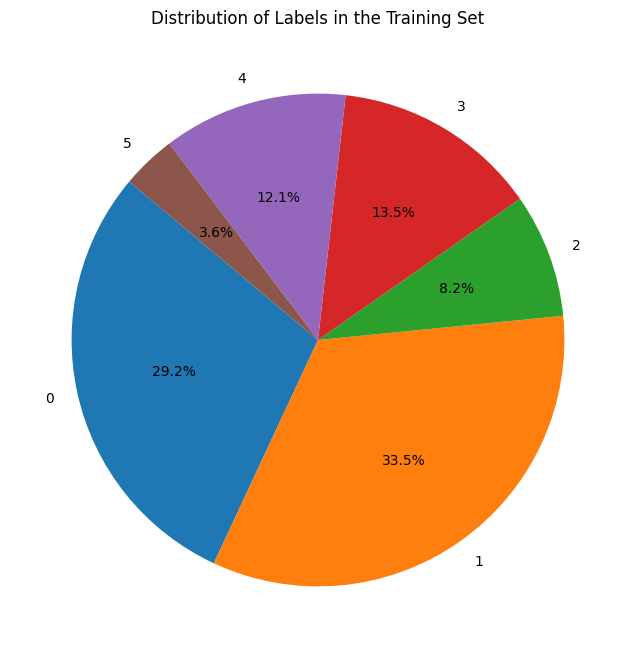

Class Weights: {0: 3.4290612944706385, 1: 2.9839612085042893, 2: 12.269938650306749, 3: 7.410838351088467, 4: 8.260196179659268, 5: 27.972027972027973}


In [151]:
##########################################################################################################################
# TODO: Analyze the distribution of labels in the training set. (visualize it in a perfect way)                          #
# Determine if there is any class imbalance.                                                                             #
# If you observe any imbalance, apply one of the techniques you have learned throughout the course to address the issue. #
##########################################################################################################################

labels_distribution = {label: labels.count(label) for label in set(labels)}

plt.figure(figsize=(8, 8))
plt.pie(labels_distribution.values(), labels=labels_distribution.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels in the Training Set')
plt.show()

total_samples = sum(labels_distribution.values())
ckass_weights = {label: total_samples / count for label, count in labels_distribution.items()}
print(f'Class Weights: {ckass_weights}')
sampler = WeightedRandomSampler([ckass_weights[label] for label in labels], len(labels), replacement=True)

---

## Task 7: Creating the Model

Design and implement a recurrent neural network for the task. You may utilize a sequential architecture like RNN or GRU to enhance the model's performance.

Build and compile your model using Pytorch.

**Once the model is created, summarize its structure to verify the design.**

---

In [152]:
#########################################################################################################
# TODO:                                                                                                 #
# Create a recurrent neural network model for the task.                                                 #
# (Suggestion: Implement a Bidirectional LSTM architecture to process the input sequences effectively.) #
# Once the model is created, summarize its structure to verify the design.                              #
#########################################################################################################
class BiLSTM(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1):
        super(BiLSTM, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.fc = torch.nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        return self.fc(output[:, -1, :])


tokenized_tweets = [tokenize_tweet(tokenizer, tweet) for tweet in tweets]
vocab = {word: i + 1 for i, word in enumerate({word for tweet in tokenized_tweets for word in tweet})}
vocab_size = len(vocab) + 1
embedding_dim = 100
hidden_dim = 128
output_dim = len(set(labels))
n_layers = 1

model = BiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers)

print(model)

BiLSTM(
  (embedding): Embedding(15203, 100)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)


---

## Task 8: Training the Model

In this task, you will prepare a validation set and train your model using the training data.

1. Prepare the validation set by extracting tweets and labels, and convert them into sequences using the tokenizer.
2. Train the model on the training data.
3. Ensure that you implement **Early Stopping** to prevent overfitting and enhance efficiency.

Make sure to monitor the validation accuracy during training and adjust the parameters as necessary.

---

In [157]:
from torch.utils.data import TensorDataset, DataLoader
###############################################################################################################
# TODO: Extract the tweets and labels from the validation set. Convert the tweets into sequences using the    #
#       tokenizer defined earlier. Prepare the data for validation and ensure it matches the format of the    #
#       training set.                                                                                         #
###############################################################################################################

# Your code for extracting and processing validation data goes here
validation_tweets, validation_labels = extract_tweets_labels(validation)
padded_validation_sequences = get_sequences(tokenizer, validation_tweets, vocab, max_length=40)

###############################################################################################################
# TODO: Train the model on the prepared training data. Ensure you implement early stopping to monitor the     #
#       validation accuracy and prevent overfitting. Adjust the number of epochs or other hyperparameters as  #
#       needed to optimize model performance.                                                                 #
###############################################################################################################

# Your code for training the model with early stopping goes here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20
batch_size = 64

train_data = TensorDataset(padded_train_sequences, torch.tensor(labels, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
valid_data = TensorDataset(padded_validation_sequences, torch.tensor(validation_labels, dtype=torch.long))
valid_loader = DataLoader(valid_data, batch_size=batch_size)

class Hist():
    def __init__(self):
        self.history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20, patience=5):
    hist = Hist()
    best_val_loss = np.inf
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        for inputs, lables in train_loader:
            inputs, lables = inputs.to(device), lables.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, lables)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_correct += (outputs.argmax(1) == lables).sum().item()
            
        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)
        
        model.eval()
        val_loss = 0
        val_correct = 0
        with torch.no_grad():
            for inputs, lables in val_loader:
                inputs, lables = inputs.to(device), lables.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, lables)
                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == lables).sum().item()
            
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)
        
        hist.history['loss'].append(train_loss)
        hist.history['accuracy'].append(train_accuracy)
        hist.history['val_loss'].append(val_loss)
        hist.history['val_accuracy'].append(val_accuracy)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break
        
        print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}')
        
    return hist

history = train_model(model, train_loader, valid_loader, criterion, optimizer, device, n_epochs)

Epoch 1/20 | Train Loss: 0.0231 | Train Acc: 0.9929 | Val Loss: 0.5630 | Val Acc: 0.8895
Epoch 2/20 | Train Loss: 0.0214 | Train Acc: 0.9940 | Val Loss: 0.5312 | Val Acc: 0.8845
Epoch 3/20 | Train Loss: 0.0101 | Train Acc: 0.9966 | Val Loss: 0.5879 | Val Acc: 0.8890
Epoch 4/20 | Train Loss: 0.0137 | Train Acc: 0.9954 | Val Loss: 0.5729 | Val Acc: 0.8925
Epoch 5/20 | Train Loss: 0.0089 | Train Acc: 0.9974 | Val Loss: 0.5773 | Val Acc: 0.8885
Epoch 6/20 | Train Loss: 0.0117 | Train Acc: 0.9966 | Val Loss: 0.5946 | Val Acc: 0.8880
Early stopping!


---

## Task 9: Evaluating the Model

In this task, you will evaluate the performance of your model on the test set and visualize the training history. You will also analyze the model’s predictions on both individual and complete test samples.

### Steps:
1. Visualize the loss and accuracy over the training epochs.
2. Prepare and preprocess the test data using functions from Task 2.
3. Evaluate the model on the test set and examine individual predictions.
4. Analyze the overall predictions and display a confusion matrix.

---

In [ ]:
###############################################################################################################
# TODO: Visualize the training history by plotting the loss and accuracy over the epochs to assess model      #
#       performance. Use an appropriate visualization method to ensure clarity and effectiveness.             #
#       you can use function implemented in Task 2 for your visualizations                                    #
###############################################################################################################

# Your code for visualizing the training history goes here
plot_history(history)


In [158]:
###############################################################################################################
# TODO: Prepare the test set by extracting the tweets and labels, then convert the tweets into sequences using #
#       the tokenizer. Ensure the format matches that of the training and validation sets.                     #
###############################################################################################################

# Your code for preparing the test set goes here

test_tweets, test_labels = extract_tweets_labels(test)
padded_test_sequences = get_sequences(tokenizer, test_tweets, vocab, max_length=40)

test_data = TensorDataset(padded_test_sequences, torch.tensor(test_labels, dtype=torch.long))
test_loader = DataLoader(test_data, batch_size=batch_size)

In [159]:
###############################################################################################################
# TODO: Evaluate the model's performance on the test set. Print the accuracy and loss, and review individual   #
#       predictions to understand how the model is performing on unseen data.                                 #
###############################################################################################################

# Your code for evaluating the model and reviewing predictions goes here

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    test_correct = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, lables in test_loader:
            inputs, lables = inputs.to(device), lables.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, lables)
            test_loss += loss.item() * inputs.size(0)
            test_correct += (outputs.argmax(1) == lables).sum().item()
            predictions.extend(outputs.argmax(1).tolist())
            actuals.extend(lables.tolist())
            
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_correct / len(test_loader.dataset)
    return test_loss, test_accuracy, predictions, actuals

test_loss, test_accuracy, predictions, actuals = evaluate_model(model, test_loader, criterion, device)

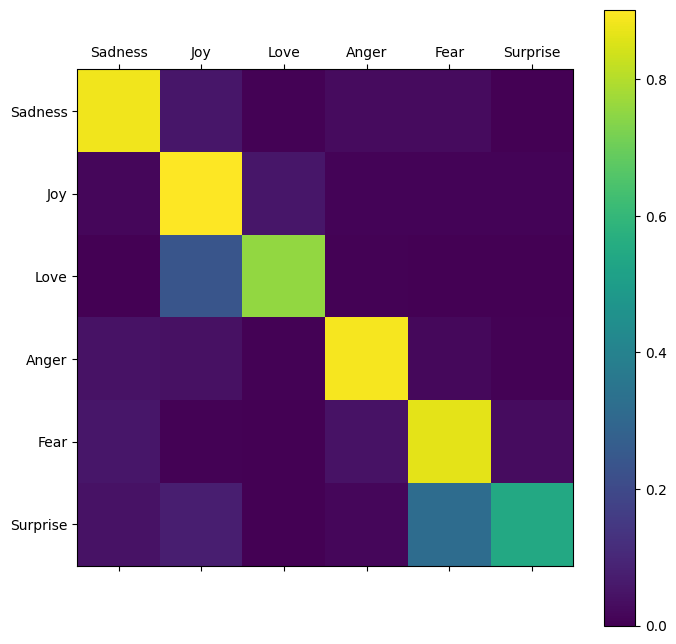

In [166]:
###############################################################################################################
# TODO: Generate predictions for all test samples and analyze the model's overall performance. Display the     #
#       confusion matrix to visualize the differences between true and predicted labels, helping to interpret  #
#       the model's classification results.                                                                   #
###############################################################################################################

# Your code for generating predictions and displaying the confusion matrix goes here
class_names = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
cm = visualize_confusion_matrix(actuals, predictions, class_names.values())

# Final Analysis

After visualizing the confusion matrix based on your model’s predictions, analyze the results and provide insights into the model’s classification performance.

### **Question:**
<span style="font-size: 1.2em;">Which class seems to get confused with the class *love* the most?</span>

**Remember the class labels:**
- **0:** *Sadness*
- **1:** *Joy*
- **2:** *Love*
- **3:** *Anger*
- **4:** *Fear*
- **5:** *Surprise*

Reflect on the confusion matrix to answer this question and provide your reasoning for why this confusion might occur based on the emotional nature of the classes.


In [167]:
# Which class seems to get confused with the class *love* the most?</span>
love_idx = 2
confusion_row = cm[love_idx]
confusion_row[love_idx] = 0
confused_class = class_names[np.argmax(confusion_row)]
print(f'The class that gets confused with Love the most is {confused_class}.')

The class that gets confused with Love the most is Joy.


# **Best regards.**